# Inference Prototype

### Imports

In [2]:
from ultralytics import YOLO
from shapely import Polygon, minimum_bounding_radius

### Load Model

In [3]:
# Path to the finetuned model weights
weights_path = '/home/adam/IDM/research/models/Yolo/version1/training/runs/segment/train/weights/best.pt'

# Load a model
model = YOLO(weights_path)  # pretrained YOLO11n model

# Path to image to run inference on
img_path = '/home/adam/IDM/data/object-detection/labeled_images_yolov11/test/images/raw_image_11_section4_jpg.rf.6cded86a5a8220905a92b94e2f3e214e.jpg' 

### Run Inference

In [4]:
# Run batched inference on a list of images
results = model(img_path)  # return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    #result.show()  # display to screen
    result.save(filename="tests/test1.jpg")  # save to disk
       
    


image 1/1 /home/adam/IDM/data/object-detection/labeled_images_yolov11/test/images/raw_image_11_section4_jpg.rf.6cded86a5a8220905a92b94e2f3e214e.jpg: 448x640 1 Cattle-Track, 14 Natives, 2 Parkinsonias, 727.3ms
Speed: 11.5ms preprocess, 727.3ms inference, 22.5ms postprocess per image at shape (1, 3, 448, 640)


### Convert to Polygons

In [5]:
print(result.boxes.cls) # What did we see 0 -> cattle track, 1 -> Native, 2 -> Weed
print(result.boxes.conf) # How confident are we 
#print(result.masks.xy) # What are the points in the polygon
poly_points = [(x, y) for [x, y] in result.masks.xy[1]] # List comprehenstion to convert to desired format 
polygon = Polygon(poly_points) # Polygon Created

tensor([1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 0., 1., 1.])
tensor([0.9682, 0.9601, 0.9575, 0.9349, 0.9315, 0.9276, 0.9216, 0.9204, 0.9200, 0.9188, 0.8958, 0.8832, 0.8451, 0.8311, 0.8260, 0.8085, 0.5125])


### Calculate Height Based On Canopy Diameter

In [ ]:
PIXEL_TO_METRE = 0.0136103 # Exported from meteshape, might be incorrect af of now. Also might not actually matter as the distribution might resolve this issue completely. 
canopy_radius = minimum_bounding_radius(polygon) # Minimum  Bounding Radius will act as our maximum canopy diameter
canopy_diameter = 2 * canopy_radius
canopy_diameter_metres = canopy_diameter * PIXEL_TO_METRE # Add in the pixel to metre ratio from metashape
height_metres = ((0.091*canopy_diameter_metres)**3.04/0.025)**(1/4.47) # Calculated max distance the risk can reach
print(canopy_radius * PIXEL_TO_METRE)
print(height_metres*5) # New asumption that the risk can reach 3 times the height of the canopy, That will be our three standard deviations.

1.694831018363033
3.0770370557979767


### Compute Risk Distribution

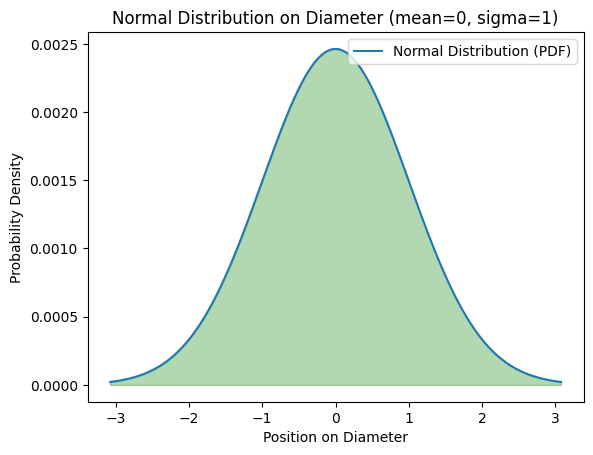

In [17]:
# EXAMPLE CODE FOR GENERATING A NORMAL DISTRUBTION, MODIFY IN ORDER TO CREATE ONE FOR THE POLYGON BASED ON HEIGHT AS DIAMETER
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
mu = 0  # Mean (center of the polygon, the center of the diameter line)
radius =  height_metres * 3 # Diameter of the circle
diameter = radius * 2  # Radius of the circle
sigma = 1  # Standard deviation for normal distribution
num_points = 1000  # Number of points for classification
num_bins = 50  # Number of bins for the histogram

# Create the x values along the diameter
x_vals = np.linspace(-radius, radius, num_points)

# Create the PDF for the normal distribution along the diameter
pdf_vals = norm.pdf(x_vals, loc=mu, scale=sigma)

# Normalize the PDF so that the sum of probabilities equals 1
pdf_vals /= np.sum(pdf_vals)

# Plot the normal distribution along the diameter
plt.plot(x_vals, pdf_vals, label="Normal Distribution (PDF)")
plt.fill_between(x_vals, pdf_vals, alpha=0.3, color='g')

# Display the plot
plt.title(f'Normal Distribution on Diameter (mean={mu}, sigma={sigma})')
plt.xlabel('Position on Diameter')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

### Score Risk Levels

In [ ]:
# For each of the other polygon object we can compute the distance between it and the weed and use the distribution to calculate the probability of risk.  We will use probability cuttoffs to determing the risk.  Or maybe like an inverse cdf

### Final Risk Analysis